In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)
        self.register_buffer("pe", pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

# class TransformerAutoencoder(nn.Module):
#     def __init__(self, time_steps, d_model=128, nhead=4, num_layers=3, latent_dim=64, dim_feedforward=256, dropout=0.1):
#         super().__init__()
#         self.input_proj = nn.Linear(1, d_model)  # Project feature dim (1) to d_model
#         self.pos_encoder = PositionalEncoding(d_model, max_len=time_steps)

#         # Transformer Encoder
#         encoder_layer = nn.TransformerEncoderLayer(
#             d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout,
#             activation="gelu", batch_first=True, norm_first=True
#         )
#         self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

#         # Latent Space Projection
#         self.latent_proj = nn.Linear(d_model, latent_dim)

#         # Transformer Decoder
#         decoder_layer = nn.TransformerDecoderLayer(
#             d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout,
#             activation="gelu", batch_first=True, norm_first=True
#         )
#         self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

#         # Output Projection
#         self.output_proj = nn.Linear(d_model, 1)

#         # Residual Layer Norm
#         self.layer_norm = nn.LayerNorm(d_model)

#     def forward(self, x):
#         # x: [batch_size, num_features=1, time_steps]
#         x = x.permute(0, 2, 1)  # [batch_size, time_steps, num_features]
#         x = self.input_proj(x)
#         x = self.pos_encoder(x)

#         # Encoder Forward Pass
#         enc_output = self.encoder(x)
#         enc_output = self.layer_norm(enc_output)

#         # Latent Space Representation
#         latent = self.latent_proj(enc_output)

#         # Decoder Forward Pass (Reconstruction)
#         dec_output = self.decoder(enc_output, enc_output)  # Using encoded input as target for reconstruction
#         dec_output = self.layer_norm(dec_output)

#         # Output Projection
#         out = self.output_proj(dec_output)  # Shape: [batch_size, time_steps, 1]
#         out = out.permute(0, 2, 1)  # Back to [batch_size, 1, time_steps]

#         return out, latent  # Returning both the reconstruction and latent space

In [4]:
class TransformerAutoencoder(nn.Module):
    def __init__(self, time_steps, d_model=128, nhead=4, num_layers=3, latent_dim=64, dim_feedforward=256, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(1, d_model)  # Project feature dim (1) to d_model
        self.pos_encoder = PositionalEncoding(d_model, max_len=time_steps)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout,
            activation="gelu", batch_first=True, norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Latent Space Projection (Global Pooling to get a single vector)
        self.latent_proj = nn.Linear(d_model, latent_dim)  # Reduce d_model → latent_dim
        self.latent_norm = nn.LayerNorm(latent_dim)  # Normalize latent space

        # Reverse Projection for Decoder Input
        self.mult_latent = 10
        self.reverse_proj = nn.Linear(latent_dim, d_model)

        # Transformer Decoder
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout,
            activation="gelu", batch_first=True, norm_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        # Output Projection
        self.output_proj = nn.Linear(d_model, 1)

        # Normalization layers
        self.encoder_norm = nn.LayerNorm(d_model)
        self.decoder_norm = nn.LayerNorm(d_model)

    def forward(self, x):
        """
        x: [batch_size, num_features=1, time_steps]
        """
        # Prepare input: [batch, time_steps, features]
        x = x.permute(0, 2, 1)
        x = self.input_proj(x)  # Project input to d_model
        x = self.pos_encoder(x)

        # Encoder Forward Pass
        enc_output = self.encoder(x)  # [batch, time_steps, d_model]
        enc_output = self.encoder_norm(enc_output)

        # Global Mean Pooling to obtain a latent vector
        # latent = enc_output.mean(dim=1, keepdim=True)  # [batch, 1, d_model] # TODO: instead of taking the mean across the time dimension, take the first 10 entries of the time dimension, and then reshape after the next latent_proj to get [batch, 1, latent_dim * 10]
        if enc_output.shape[1] < self.mult_latent:
          enc_output = enc_output.repeat(1, math.ceil(self.mult_latent / enc_output.shape[1]), 1)
          enc_output = enc_output[:,:self.mult_latent, :]
        latent = enc_output[:,:self.mult_latent,:]
        # Project to latent space and normalize → this is the true latent representation
        latent_code = self.latent_proj(latent)       # [batch, 10, latent_dim]
        latent_code = self.latent_norm(latent_code)
        latent_result = latent_code.view(latent_code.shape[0], -1)

        # Prepare input for the decoder: use reverse projection on the latent_code
        decoder_input = self.reverse_proj(latent_code)  # [batch, 10, d_model]

        # Expand decoder input back to sequence length
        repeated_decoder_input = decoder_input.repeat(1, math.ceil(x.shape[1] / self.mult_latent), 1)
        repeated_decoder_input = repeated_decoder_input[:,:x.shape[1],:] # [batch, time_steps, d_model]
        # Break symmetry: apply positional encoding to the repeated latent representation
        repeated_decoder_input = self.pos_encoder(repeated_decoder_input)

        # Decoder Forward Pass
        # Instead of using enc_output as memory (which comes before the bottleneck), we now use
        # repeated_decoder_input for both target and memory so the decoder solely relies on the bottleneck.
        dec_output = self.decoder(repeated_decoder_input, repeated_decoder_input)  # [batch, time_steps, d_model]
        dec_output = self.decoder_norm(dec_output)

        # Output Projection
        out = self.output_proj(dec_output)  # [batch, time_steps, 1]
        out = out.permute(0, 2, 1)  # Convert back to [batch, 1, time_steps]

        # Return both the reconstructed output and the latent representation (squeezed to remove the time dim)
        return out, latent_result

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [6]:
rus1000 = pd.read_csv("/content/RUSSELL_1000_5y.csv")
spy500 = pd.read_csv("/content/SPY_500_5y.csv")

<ipython-input-6-7ea928f6593c>:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263

In [41]:
y = spy500.iloc[0,1:]
y = y[np.logical_not(spy500.iloc[2:,1:].isna().any(axis=0))].tolist()
X = spy500.iloc[2:,1:].dropna(axis=1).T.astype(float)
X = X / X.iloc[:,0].values.reshape(488, 1)
X_t, X_v, y_t, y_v = train_test_split(X.values, y, test_size=0.3, random_state=0)
X_t = X_t.reshape(X_t.shape[0], 1, X_t.shape[-1])
X_v = X_v.reshape(X_v.shape[0], 1, X_v.shape[-1])

In [33]:
model = TransformerAutoencoder(X_t.shape[2]).to(device)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [ ]:
# outputs_temp, latent_temp = model(torch.zeros(32,1,5).to(device))

In [34]:
# outputs_temp.shape, latent_temp.shape

In [54]:
train_dataset = TensorDataset(torch.tensor(X_t, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_v, dtype=torch.float32))
all_dataset = TensorDataset(torch.tensor(X.values.reshape(X.shape[0], 1, X.shape[-1]), dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
all_loader = DataLoader(all_dataset, batch_size=32, shuffle=False)

In [36]:
def train_autoencoder(model, train_loader, val_loader, num_epochs=50, lr=1e-4, device="cuda"):
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for (batch, ) in train_loader:
            x = batch.to(device)  # Move batch to GPU/CPU
            optimizer.zero_grad()
            outputs, _ = model(x)  # Forward pass
            loss = criterion(outputs, x)  # Compare to original input
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            train_loss += loss.item()

        # Compute average training loss
        train_loss /= len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for (batch, ) in val_loader:
                x = batch.to(device)
                outputs, _ = model(x)
                loss = criterion(outputs, x)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        # Print epoch losses
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    return model

In [108]:
model = train_autoencoder(model, train_loader, val_loader, num_epochs=50, lr=1e-4, device=device)

Epoch [1/50] - Train Loss: 0.5768 | Val Loss: 0.1556
Epoch [2/50] - Train Loss: 0.5032 | Val Loss: 0.1459
Epoch [3/50] - Train Loss: 0.5074 | Val Loss: 0.1437
Epoch [4/50] - Train Loss: 0.4858 | Val Loss: 0.1438
Epoch [5/50] - Train Loss: 0.4827 | Val Loss: 0.1469
Epoch [6/50] - Train Loss: 0.4841 | Val Loss: 0.1424
Epoch [7/50] - Train Loss: 0.4746 | Val Loss: 0.1480
Epoch [8/50] - Train Loss: 0.4705 | Val Loss: 0.1449
Epoch [9/50] - Train Loss: 0.4703 | Val Loss: 0.1403
Epoch [10/50] - Train Loss: 0.4642 | Val Loss: 0.1463
Epoch [11/50] - Train Loss: 0.4611 | Val Loss: 0.1405
Epoch [12/50] - Train Loss: 0.4562 | Val Loss: 0.1459
Epoch [13/50] - Train Loss: 0.4512 | Val Loss: 0.1431
Epoch [14/50] - Train Loss: 0.4488 | Val Loss: 0.1386
Epoch [15/50] - Train Loss: 0.4435 | Val Loss: 0.1358
Epoch [16/50] - Train Loss: 0.4420 | Val Loss: 0.1284


KeyboardInterrupt: 

In [ ]:
# X_temp = next(iter(val_loader))[0].to(device)
# outputs, latent = model(X_temp)

In [ ]:
# torch.nn.CosineSimilarity(dim=2)(X_temp, outputs)

In [ ]:
# torch.linalg.norm(X_temp), torch.linalg.norm(outputs)

In [109]:
torch.save(model.state_dict(), "model.pth")
# model.load_state_dict(torch.load("model.pth"))

In [39]:
# X_t.shape

In [110]:
model.eval()
latents = []
avg_daily_percent_change = []
overall_percent_change = []
train_val = [0 for i in range(len(train_loader.dataset))] + [1 for i in range(len(val_loader.dataset))]

special_idx = 1
ref = torch.tensor(X_t[special_idx], dtype=torch.float32).unsqueeze(0).to(device)
ref = ref.view(ref.shape[0],-1)
ref_mean = ref.mean()
ref_std = ref.std()
corrs = []

# with torch.no_grad():
#     for (batch, ) in all_loader:
#         x = batch.to(device)
#         output, latent = model(x)
#         # print(latent.shape)
#         latents.append(latent.cpu().detach().numpy())
#         avg_daily_percent_change += (x.diff() / x[:,:,:-1]).mean(dim=-1).flatten().tolist()
#         overall_percent_change += ((x[:,:,-1] - x[:,:,0]) / x[:,:,0]).flatten().tolist()
with torch.no_grad():
    for (batch, ) in train_loader:
        x = batch.to(device)
        output, latent = model(x)
        # print(latent.shape)
        latents.append(latent.cpu().detach().numpy())
        avg_daily_percent_change += (x.diff() / x[:,:,:-1]).mean(dim=-1).flatten().tolist()
        overall_percent_change += ((x[:,:,-1] - x[:,:,0]) / x[:,:,0]).flatten().tolist()
        others = x.view(x.shape[0], -1)
        others_mean = others.mean(dim=1, keepdim=True)
        others_std = others.std(dim=1, keepdim=True)
        cov = ((others - others_mean) * (ref - ref_mean)).sum(dim=1) / (others.shape[-1] - 1)
        corr = cov / (ref_std * others_std.squeeze())
        corrs += corr.tolist()

with torch.no_grad():
    for (batch, ) in val_loader:
        x = batch.to(device)
        output, latent = model(x)
        # print(latent.shape)
        latents.append(latent.cpu().detach().numpy())
        avg_daily_percent_change += (x.diff() / x[:,:,:-1]).mean(dim=-1).flatten().tolist()
        overall_percent_change += ((x[:,:,-1] - x[:,:,0]) / x[:,:,0]).flatten().tolist()
        others = x.view(x.shape[0], -1)
        others_mean = others.mean(dim=1, keepdim=True)
        others_std = others.std(dim=1, keepdim=True)
        cov = ((others - others_mean) * (ref - ref_mean)).sum(dim=1) / (others.shape[-1] - 1)
        corr = cov / (ref_std * others_std.squeeze())
        corrs += corr.tolist()
latents = np.concatenate(latents)
overall_percent_change_clipped = np.clip(overall_percent_change, np.percentile(overall_percent_change, 5), np.percentile(overall_percent_change, 95))
tickers = pd.Series(y_t + y_v)
X_total = np.concatenate((X_t, X_v))

In [111]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [112]:
pca = PCA(n_components=2)
latents_transformed = pca.fit_transform(latents)
print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))

[0.90409714 0.05653366]
0.9606308


In [113]:
latents.shape, latents_transformed.shape

((488, 640), (488, 2))

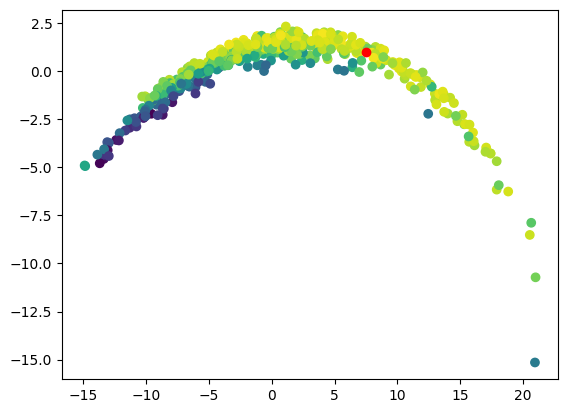

In [114]:
plt.scatter(latents_transformed[:,0], latents_transformed[:,1], c=corrs)
plt.scatter(latents_transformed[special_idx,0], latents_transformed[special_idx,1], c="red")

(array([ 10.,  12.,  16.,  23.,  18.,  21.,  25.,  81., 118., 164.]),
 array([-0.65927571, -0.49334812, -0.32742052, -0.16149293,  0.00443467,
         0.17036226,  0.33628986,  0.50221745,  0.66814505,  0.83407264,
         1.00000024]),
 <BarContainer object of 10 artists>)

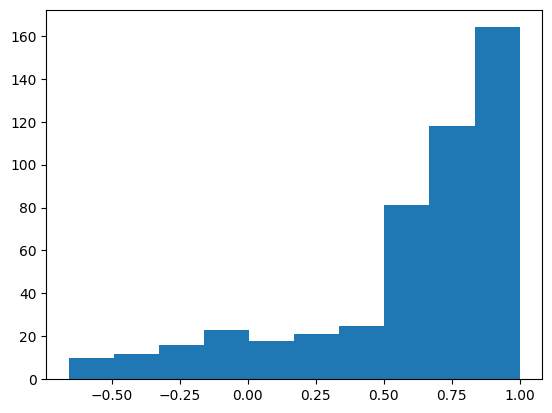

In [115]:
plt.hist(corrs)

In [116]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(latents)

KMeans(n_clusters=10)

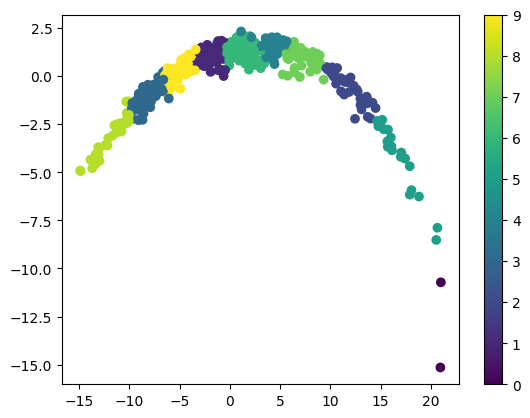

In [125]:
plt.scatter(latents_transformed[:,0], latents_transformed[:,1], c=kmeans.labels_)
plt.colorbar()
plt.show()

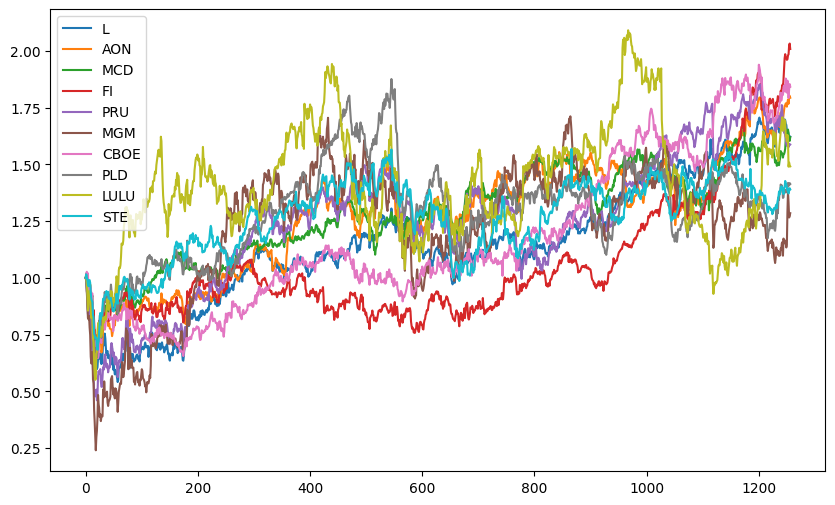

['L', 'AON', 'MCD', 'FI', 'PRU', 'MGM', 'CBOE', 'PLD', 'LULU', 'STE']
['VICI', 'ROP', 'CE', 'ITW', 'MNST', 'TYL', 'PEG', 'DXCM', 'ABT', 'ALL', 'EQIX', 'OKE', 'EG', 'WTW', 'PRU', 'AON', 'LKQ', 'V', 'MCD', 'OXY', 'PG', 'LYB', 'DOW', 'NDSN', 'OMC', 'LULU', 'CBOE', 'KIM', 'HPE', 'J', 'CRL', 'MGM', 'GM', 'NOC', 'TRMB', 'RVTY', 'LH', 'ROK', 'TTWO', 'CSX', 'PLD', 'AMGN', 'ULTA', 'VRSK', 'ICE', 'EPAM', 'WELL', 'IQV', 'CHD', 'CHRW', 'XYL', 'HOLX', 'GIS', 'IP', 'L', 'CRM', 'LYV', 'WDAY', 'DRI', 'HSY', 'YUM', 'UNP', 'WFC', 'MA', 'AIZ', 'STE', 'FI', 'DGX', 'ADBE', 'MO', 'ALGN']


In [154]:
plt.figure(figsize=(10,6))
cluster_num = 1
idxs = [i == cluster_num for i in kmeans.labels_]
idxs2 = [i for i in range(len(kmeans.labels_)) if kmeans.labels_[i] == cluster_num]
rows_select = np.random.choice(idxs2,min(10,len(idxs2)),replace=False)
plt.plot(X_total[rows_select,0,:].T, label=tickers.iloc[rows_select].tolist())
plt.legend(loc="upper left")
plt.show()
print(tickers.iloc[rows_select].tolist())
print(tickers[idxs].tolist())

In [103]:
X_total[rows_select,0,:].shape

(5, 1257)

In [136]:
# TODO: get back stock names for clusters and see if they make sense
# TODO: elbow method for number of clusters
# TODO: train model for longer
# TODO: feed tickers for each cluster into LLM and decide name for clusters
# TODO: do recursive/hierarchical clustering, then do labeling